In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from scipy.stats import multivariate_normal as mvn
import seaborn as sns
import sys
sys.path.append(os.path.abspath('../../utils'))
from utils_preproc import get_fenceposts
%matplotlib inline

In [2]:
def visualize2D_new(data_DTN=None, y_N=None, mu_all=None, cov_all=None, levels=3, 
                colorlist=['salmon', 'blue'], markerlist=['$x$', '$o$'], alpha=0.3, 
                    missing_handling="", perc_obs='20', savename=None):
    
    f, ax = plt.subplots(figsize=(15, 5))
    sns.set_context("notebook", font_scale=1.4)
    sns.set_style("whitegrid")
    
    ordinal_labels_num = np.max(y_N)+1
    for ordinal_label in range(ordinal_labels_num)[::-1]:
        inds_curr_label = y_N==ordinal_label
        feature_vals_ND_labels_y = data_DTN[:, :, inds_curr_label]

        # plot time series sequence of example with label 0 and 1
        ax.scatter(feature_vals_ND_labels_y[0, :], feature_vals_ND_labels_y[1, :],
                    marker='$x$', linestyle=':', alpha=0.5, label=f'y={ordinal_label}')
        
        ax.set_yticks(np.arange(-5, 5))
        ax.tick_params(axis='y', which='both')
        ax.legend(bbox_to_anchor=(1.02, 1))
    fontsize=10
    
#     ax.set_xlim([-5, 30])
#     ax.set_ylim([-5, 3])
    
    
    for ii in range(mu_all.shape[0]):
        D = len(mu_all[ii])
        cov_DD = np.diag(cov_all[ii, :])
        mu_D = mu_all[ii]
        
        # Decompose cov matrix into eigenvalues "lambda[d]" and eigenvectors "U[:,d]"
        lambda_D, U_DD = np.linalg.eig(cov_DD)

        # Verify orthonormal
        assert np.allclose(np.eye(D), np.dot(U_DD, U_DD.T))
        # View eigenvector matrix as a rotation transformation
        rot_DD = U_DD

        # Prep for plotting elliptical contours
        # by creating grid of G different (x,y) points along perfect circle
        # Recall that a perfect circle is swept by considering all radians between [-pi, +pi]
        unit_circle_radian_step_size=0.03
        t_G = np.arange(-np.pi, np.pi, unit_circle_radian_step_size)
        x_G = np.sin(t_G)
        y_G = np.cos(t_G)
        Zcirc_DG = np.vstack([x_G, y_G])

        # Warp circle into ellipse defined by Sigma's eigenvectors
        # Rescale according to eigenvalues
        Zellipse_DG = np.sqrt(lambda_D)[:,np.newaxis] * Zcirc_DG
        # Rotate according to eigenvectors
        Zrotellipse_DG = np.dot(rot_DD, Zellipse_DG)
        
        radius_lengths=[1.0, 2.0, 3.0]
        
        # Plot contour lines across several radius lengths
        for r in radius_lengths:
            Z_DG = r * Zrotellipse_DG + mu_D[:, np.newaxis]
            plt.plot(
                Z_DG[0], Z_DG[1], '.-',
                color='k',
                markersize=3.0,
                markerfacecolor='k',
                markeredgecolor='k')
            
        if savename is not None:
            f.savefig(savename, bbox_inches='tight')
    plt.show()

## Get the toy data

In [3]:
data_dir = os.path.abspath('../data/toydata_many_states')

x_train_np_filename=os.path.join(data_dir, 'X_train.npy')
x_valid_np_filename=os.path.join(data_dir, 'X_valid.npy')
x_test_np_filename=os.path.join(data_dir, 'X_test.npy')
y_train_np_filename=os.path.join(data_dir, 'y_train.npy')
y_valid_np_filename=os.path.join(data_dir, 'y_valid.npy')
y_test_np_filename=os.path.join(data_dir, 'y_test.npy')


X_train = np.load(x_train_np_filename)
X_test = np.load(x_test_np_filename)
X_val = np.load(x_valid_np_filename)

y_train = np.load(y_train_np_filename)
y_test = np.load(y_test_np_filename)
y_val = np.load(y_valid_np_filename)

data_DTN = np.transpose(np.vstack([X_train, X_val, X_test]), (2, 1, 0))
y_N = np.concatenate([y_train, y_val, y_test])

# get the data
# features_df = pd.read_csv(os.path.join(data_dir, "features_2d_per_tstep_%s_observed=%s_perc.csv"%(missing_handling, perc_obs)))
# outcomes_df = pd.read_csv(os.path.join(data_dir, "outcomes_per_seq.csv"))

# features_outcomes_df = pd.merge(features_df, outcomes_df, on='sequence_id')

# # get the data in D x T x N form
# data_DTN_list = []
# id_cols = ['sequence_id']
# fp = get_fenceposts(features_outcomes_df, id_cols)
# n_rows = len(fp)-1
# feature_cols = ['temperature_1', 'temperature_2']
# features_arr = features_outcomes_df[feature_cols].values
# for p in range(n_rows):
#     data_DTN_list.append(features_arr[fp[p]:fp[p+1], :])

# data_DTN = np.stack(data_DTN_list).T
# features_outcomes_df.drop_duplicates(subset=id_cols, inplace=True)
# y_N = features_outcomes_df['ordinal_label'].values

## Plot the best fit

/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/toydata/ordinal_training_logs/pchmm_many_states/final_perf_pchmm-missing_handling=no_imp-perc_obs=100-lr=0.05-seed=123-n_states=40-batch_size=-1-lamb=500.csv
--------------------------------------
MISSING HANDLING = no_imp perc observed = 100
   train_AUC_mean  valid_AUC_mean  test_AUC_mean  train_AUPRC_mean  \
0        0.977987        0.745877        0.62311          0.886537   

   valid_AUPRC_mean  test_AUPRC_mean  train_AUC_0  train_AUPRC_0  valid_AUC_0  \
0          0.447083          0.33975     0.999996       0.999995     0.834897   

   valid_AUPRC_0  ...  test_AUC_2  test_AUPRC_2  train_AUC_3  train_AUPRC_3  \
0       0.852731  ...      0.5854      0.180326          1.0            1.0   

   valid_AUC_3  valid_AUPRC_3  test_AUC_3  test_AUPRC_3  \
0     0.771402       0.360418    0.666537      0.293785   

                        model  perc_obs  
0  PCHMM no imputation (ours)       100  

[1 rows x 32 c

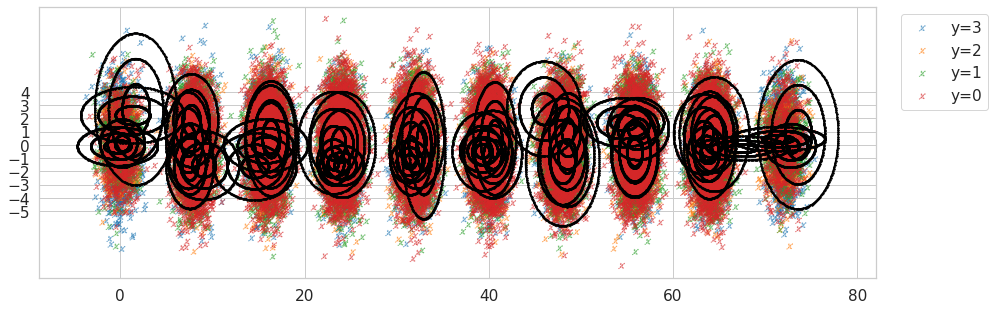

/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/toydata/ordinal_training_logs/pchmm_many_states/final_perf_pchmm-missing_handling=no_imp-perc_obs=100-lr=0.1-seed=529-n_states=40-batch_size=-1-lamb=1.csv
--------------------------------------
MISSING HANDLING = no_imp perc observed = 100
   train_AUC_mean  valid_AUC_mean  test_AUC_mean  train_AUPRC_mean  \
0        0.979103        0.730922        0.64445          0.903507   

   valid_AUPRC_mean  test_AUPRC_mean  train_AUC_0  train_AUPRC_0  valid_AUC_0  \
0           0.42914         0.368879          1.0            1.0     0.836912   

   valid_AUPRC_0  ...  test_AUC_2  test_AUPRC_2  train_AUC_3  train_AUPRC_3  \
0       0.856955  ...    0.696759      0.273268          1.0            1.0   

   valid_AUC_3  valid_AUPRC_3  test_AUC_3  test_AUPRC_3  \
0     0.792305       0.361107    0.687969      0.361432   

                        model  perc_obs  
0  PCHMM no imputation (ours)       100  

[1 rows x 32 colu

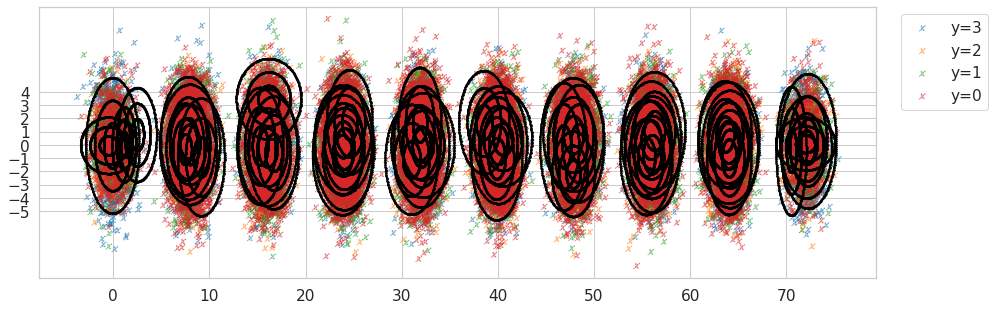

/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/toydata/ordinal_training_logs/pchmm_many_states/final_perf_pchmm-missing_handling=no_imp-perc_obs=100-lr=0.05-seed=521-n_states=40-batch_size=-1-lamb=5000.csv
--------------------------------------
MISSING HANDLING = no_imp perc observed = 100
   train_AUC_mean  valid_AUC_mean  test_AUC_mean  train_AUPRC_mean  \
0        0.995899        0.730835       0.632898          0.984671   

   valid_AUPRC_mean  test_AUPRC_mean  train_AUC_0  train_AUPRC_0  valid_AUC_0  \
0          0.424307         0.364207          1.0            1.0     0.829963   

   valid_AUPRC_0  ...  test_AUC_2  test_AUPRC_2  train_AUC_3  train_AUPRC_3  \
0       0.846097  ...    0.597222      0.210113          1.0            1.0   

   valid_AUC_3  valid_AUPRC_3  test_AUC_3  test_AUPRC_3  \
0     0.796565       0.372197    0.667055      0.298107   

                        model  perc_obs  
0  PCHMM no imputation (ours)       100  

[1 rows x 32 

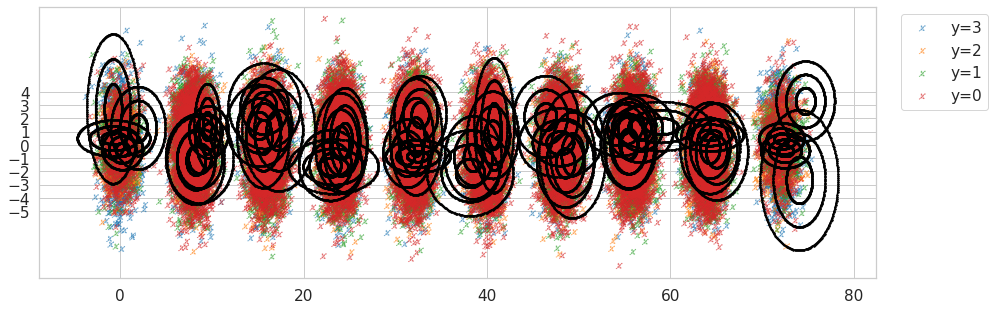

/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/toydata/ordinal_training_logs/pchmm_many_states/final_perf_pchmm-missing_handling=no_imp-perc_obs=100-lr=0.05-seed=42-n_states=40-batch_size=-1-lamb=5.csv
--------------------------------------
MISSING HANDLING = no_imp perc observed = 100
   train_AUC_mean  valid_AUC_mean  test_AUC_mean  train_AUPRC_mean  \
0        0.984032        0.728551       0.611157           0.93672   

   valid_AUPRC_mean  test_AUPRC_mean  train_AUC_0  train_AUPRC_0  valid_AUC_0  \
0          0.447028         0.343377          1.0            1.0     0.806546   

   valid_AUPRC_0  ...  test_AUC_2  test_AUPRC_2  train_AUC_3  train_AUPRC_3  \
0       0.841704  ...     0.53125      0.161985          1.0            1.0   

   valid_AUC_3  valid_AUPRC_3  test_AUC_3  test_AUPRC_3  \
0     0.796831       0.379041    0.703898      0.329922   

                        model  perc_obs  
0  PCHMM no imputation (ours)       100  

[1 rows x 32 colu

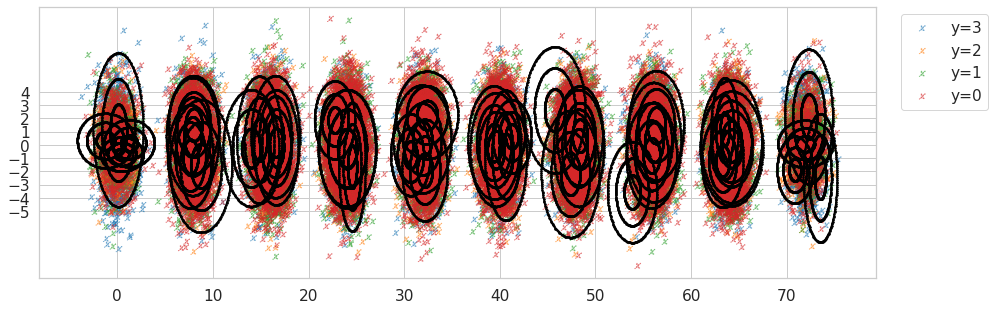

/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/toydata/ordinal_training_logs/pchmm_many_states/final_perf_pchmm-missing_handling=no_imp-perc_obs=100-lr=0.1-seed=1238-n_states=40-batch_size=-1-lamb=1000.csv
--------------------------------------
MISSING HANDLING = no_imp perc observed = 100
   train_AUC_mean  valid_AUC_mean  test_AUC_mean  train_AUPRC_mean  \
0         0.95021        0.727796        0.66616          0.823129   

   valid_AUPRC_mean  test_AUPRC_mean  train_AUC_0  train_AUPRC_0  valid_AUC_0  \
0          0.412353         0.395991     0.999934       0.999922     0.838719   

   valid_AUPRC_0  ...  test_AUC_2  test_AUPRC_2  train_AUC_3  train_AUPRC_3  \
0       0.855985  ...    0.592262      0.207679          1.0            1.0   

   valid_AUC_3  valid_AUPRC_3  test_AUC_3  test_AUPRC_3  \
0     0.744641        0.29923    0.694768      0.318848   

                        model  perc_obs  
0  PCHMM no imputation (ours)       100  

[1 rows x 32 

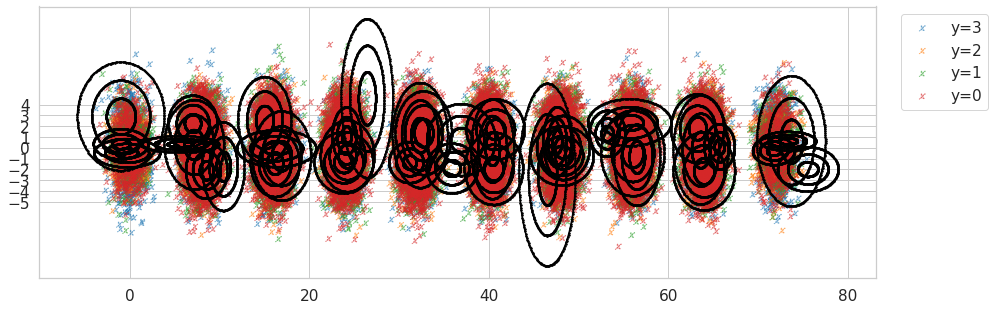

/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/toydata/ordinal_training_logs/pchmm_many_states/final_perf_pchmm-missing_handling=no_imp-perc_obs=100-lr=0.1-seed=98-n_states=40-batch_size=-1-lamb=5.csv
--------------------------------------
MISSING HANDLING = no_imp perc observed = 100
   train_AUC_mean  valid_AUC_mean  test_AUC_mean  train_AUPRC_mean  \
0        0.962044        0.725646       0.657976          0.847859   

   valid_AUPRC_mean  test_AUPRC_mean  train_AUC_0  train_AUPRC_0  valid_AUC_0  \
0          0.412651         0.379148          1.0            1.0     0.827323   

   valid_AUPRC_0  ...  test_AUC_2  test_AUPRC_2  train_AUC_3  train_AUPRC_3  \
0       0.852508  ...     0.62872      0.225323          1.0            1.0   

   valid_AUC_3  valid_AUPRC_3  test_AUC_3  test_AUPRC_3  \
0     0.810545       0.336734    0.695286       0.31718   

                        model  perc_obs  
0  PCHMM no imputation (ours)       100  

[1 rows x 32 colum

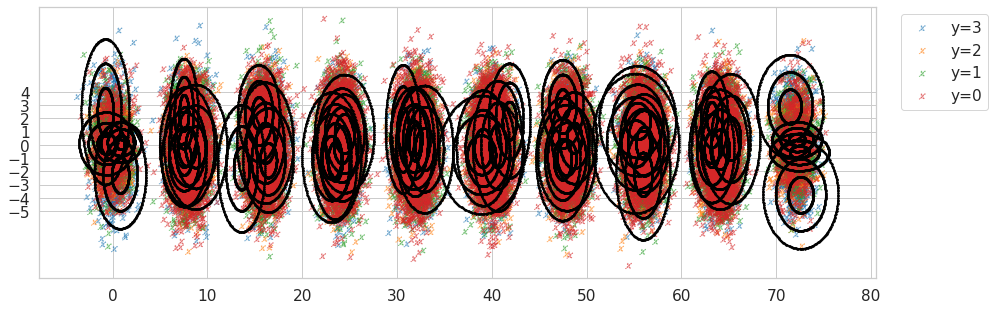

/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/toydata/ordinal_training_logs/pchmm_many_states/final_perf_pchmm-missing_handling=no_imp-perc_obs=100-lr=0.1-seed=5-n_states=40-batch_size=-1-lamb=100.csv
--------------------------------------
MISSING HANDLING = no_imp perc observed = 100
   train_AUC_mean  valid_AUC_mean  test_AUC_mean  train_AUPRC_mean  \
0        0.998906        0.725358       0.647337          0.997007   

   valid_AUPRC_mean  test_AUPRC_mean  train_AUC_0  train_AUPRC_0  valid_AUC_0  \
0          0.446319         0.379172          1.0            1.0     0.812244   

   valid_AUPRC_0  ...  test_AUC_2  test_AUPRC_2  train_AUC_3  train_AUPRC_3  \
0       0.825977  ...    0.617725      0.287604          1.0            1.0   

   valid_AUC_3  valid_AUPRC_3  test_AUC_3  test_AUPRC_3  \
0     0.798429       0.428671    0.690365      0.314457   

                        model  perc_obs  
0  PCHMM no imputation (ours)       100  

[1 rows x 32 colu

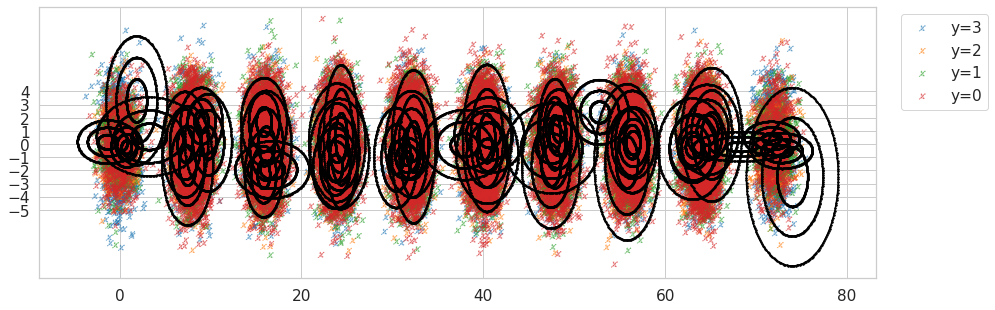

/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/toydata/ordinal_training_logs/pchmm_many_states/final_perf_pchmm-missing_handling=no_imp-perc_obs=100-lr=0.1-seed=786-n_states=40-batch_size=-1-lamb=500.csv
--------------------------------------
MISSING HANDLING = no_imp perc observed = 100
   train_AUC_mean  valid_AUC_mean  test_AUC_mean  train_AUPRC_mean  \
0        0.974559        0.723231        0.63329            0.8683   

   valid_AUPRC_mean  test_AUPRC_mean  train_AUC_0  train_AUPRC_0  valid_AUC_0  \
0          0.421083         0.368815          1.0            1.0     0.822389   

   valid_AUPRC_0  ...  test_AUC_2  test_AUPRC_2  train_AUC_3  train_AUPRC_3  \
0       0.841506  ...    0.653356       0.28881          1.0            1.0   

   valid_AUC_3  valid_AUPRC_3  test_AUC_3  test_AUPRC_3  \
0     0.751032       0.301065    0.696711      0.324656   

                        model  perc_obs  
0  PCHMM no imputation (ours)       100  

[1 rows x 32 co

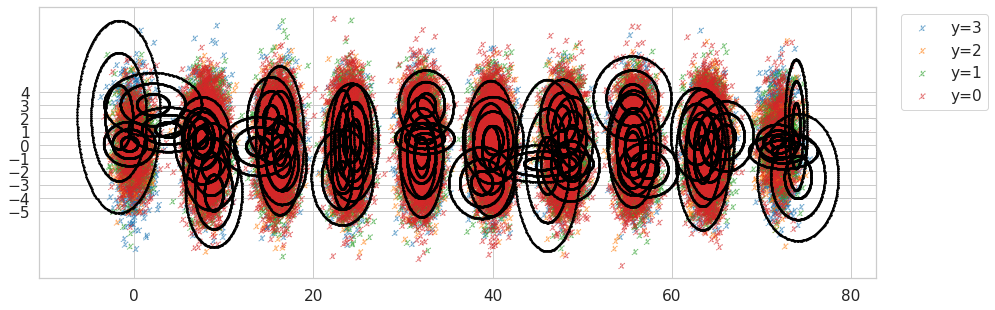

/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/toydata/ordinal_training_logs/pchmm_many_states/final_perf_pchmm-missing_handling=no_imp-perc_obs=100-lr=0.05-seed=1238-n_states=40-batch_size=-1-lamb=100.csv
--------------------------------------
MISSING HANDLING = no_imp perc observed = 100
   train_AUC_mean  valid_AUC_mean  test_AUC_mean  train_AUPRC_mean  \
0        0.954653        0.722993        0.64766          0.821822   

   valid_AUPRC_mean  test_AUPRC_mean  train_AUC_0  train_AUPRC_0  valid_AUC_0  \
0          0.424609         0.365504          1.0            1.0      0.81551   

   valid_AUPRC_0  ...  test_AUC_2  test_AUPRC_2  train_AUC_3  train_AUPRC_3  \
0       0.840676  ...    0.610284      0.206528          1.0            1.0   

   valid_AUC_3  valid_AUPRC_3  test_AUC_3  test_AUPRC_3  \
0     0.728398        0.32543    0.700142      0.335496   

                        model  perc_obs  
0  PCHMM no imputation (ours)       100  

[1 rows x 32 

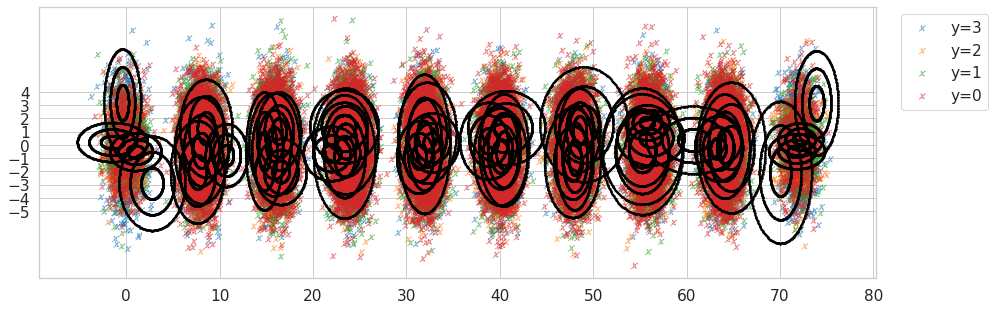

/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/toydata/ordinal_training_logs/pchmm_many_states/final_perf_pchmm-missing_handling=no_imp-perc_obs=100-lr=0.01-seed=2930-n_states=40-batch_size=-1-lamb=1000.csv
--------------------------------------
MISSING HANDLING = no_imp perc observed = 100
   train_AUC_mean  valid_AUC_mean  test_AUC_mean  train_AUPRC_mean  \
0        0.991324        0.722768       0.633564          0.973874   

   valid_AUPRC_mean  test_AUPRC_mean  train_AUC_0  train_AUPRC_0  valid_AUC_0  \
0          0.439677         0.360824     0.998322       0.998919     0.806754   

   valid_AUPRC_0  ...  test_AUC_2  test_AUPRC_2  train_AUC_3  train_AUPRC_3  \
0       0.837276  ...     0.68502      0.261834     0.999827       0.999096   

   valid_AUC_3  valid_AUPRC_3  test_AUC_3  test_AUPRC_3  \
0     0.787778       0.420754    0.716783      0.371433   

                        model  perc_obs  
0  PCHMM no imputation (ours)       100  

[1 rows x 32

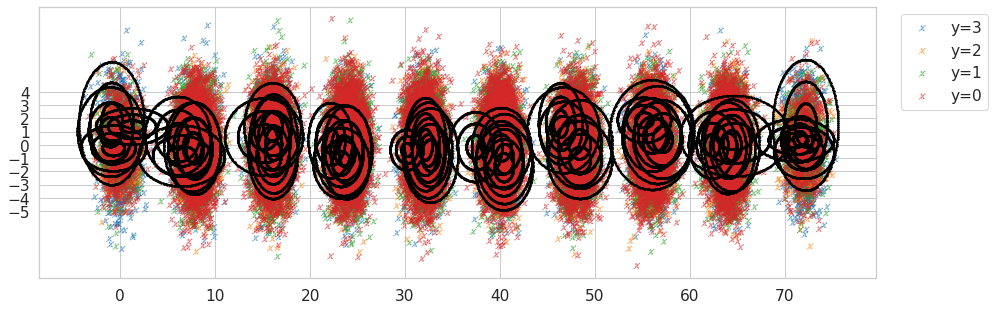

In [18]:
fits_dir = os.path.abspath('../ordinal_training_logs/pchmm_many_states/')

missing_handling_aka_dict = {'no_imp' : 'no imputation (ours)',
                            'ffill_imp' : 'forward fill imputation',
                            'mean_imp' : 'mean imputation'}

for missing_handling in ['no_imp']:
    for perc_obs in ['100']:
        all_fits_csvs = glob.glob(os.path.join(fits_dir, "final_perf*pchmm-*missing_handling=%s-*perc_obs=%s-*lr=*n_states=*lamb=*.csv"%(missing_handling, perc_obs)))
#         all_fits_csvs = glob.glob(os.path.join(fits_dir, "final_perf*pchmm-*missing_handling=%s-*perc_obs=%s-*n_states=*lamb=*.csv"%(missing_handling, perc_obs)))
        losses_per_fit_np = np.zeros(len(all_fits_csvs))
        auc_per_fit_np = np.zeros(len(all_fits_csvs))
        
        
        for ii, fit_csv in enumerate(all_fits_csvs):
            try:
                fit_df = pd.read_csv(fit_csv)
                hist_csv = fit_csv.replace('final_perf_', '')
                hist_df = pd.read_csv(hist_csv)
                lamb = int(hist_csv.replace('.csv', '').split('lamb=')[-1])
                curr_loss = hist_df['val_hmm_model_loss'].to_numpy()[-1] + (hist_df['val_predictor_loss'].to_numpy()[-1])/lamb
                val_auc = fit_df['valid_AUC_mean'].values[0]
                losses_per_fit_np[ii]=curr_loss
                auc_per_fit_np[ii]=val_auc
            except:
                losses_per_fit_np[ii] = np.inf
                auc_per_fit_np[ii] = 0
                
        sorted_losses_inds = np.argsort(losses_per_fit_np)
        sorted_auc_inds = np.argsort(auc_per_fit_np)
        for kk in range(10):
#             best_fit_ind = sorted_losses_inds[kk]
            best_fit_ind = sorted_auc_inds[-1-kk]
            best_fit_csv = all_fits_csvs[best_fit_ind]

            print(best_fit_csv)
            #get the mus and covariances of the best fit
            best_fit_mu = best_fit_csv.replace(".csv", "-fit-mu.npy").replace("final_perf_", "")
            best_fit_cov = best_fit_csv.replace(".csv", "-fit-cov.npy").replace("final_perf_", "")
            best_fit_eta = best_fit_csv.replace(".csv", "-fit-eta.npy").replace("final_perf_", "")


    #         final_perf_csv = os.path.join(fits_dir, 'final_perf_'+best_fit_csv.split('/')[-1])
            final_perf_df = pd.read_csv(best_fit_csv)
            final_hist_df = pd.read_csv(best_fit_csv.replace('final_perf_', ''))

            final_perf_df['model'] = 'PCHMM %s'%missing_handling_aka_dict[missing_handling]
            final_perf_df['perc_obs'] = perc_obs
            print('--------------------------------------')
            print('MISSING HANDLING = %s perc observed = %s'%(missing_handling, perc_obs))
            print(final_perf_df)
            print('--------------------------------------')


            mu_all = np.load(best_fit_mu)
            cov_all = np.load(best_fit_cov)
            eta_all = np.load(best_fit_eta)

            visualize2D_new(data_DTN=data_DTN, y_N=y_N, mu_all=mu_all, cov_all=cov_all, levels=3, 
                    markerlist=['$x$', '$o$'], alpha=0.3, 
                    missing_handling=missing_handling,
                   perc_obs=perc_obs, 
#                             savename='toydata_fits.png'
                           )

In [8]:
final_perf_df

,train_AUC_mean,valid_AUC_mean,test_AUC_mean,train_AUPRC_mean,valid_AUPRC_mean,test_AUPRC_mean,train_AUC_0,train_AUPRC_0,valid_AUC_0,valid_AUPRC_0,...,test_AUC_2,test_AUPRC_2,train_AUC_3,train_AUPRC_3,valid_AUC_3,valid_AUPRC_3,test_AUC_3,test_AUPRC_3,model,perc_obs
0,0.991324,0.722768,0.633564,0.973874,0.439677,0.360824,0.998322,0.998919,0.806754,0.837276,...,0.68502,0.261834,0.999827,0.999096,0.787778,0.420754,0.716783,0.371433,PCHMM no imputation (ours),100


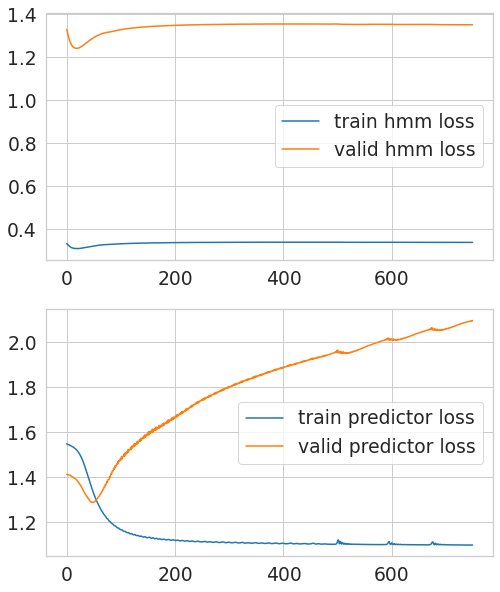

In [50]:
f, axs = plt.subplots(2, 1, figsize=(8, 10))

lamb = int(best_fit_csv.replace('.csv', '').split('lamb=')[-1])
epochs = range(len(final_hist_df))
train_hmm_loss = final_hist_df['hmm_model_loss'].values
val_hmm_loss = final_hist_df['val_hmm_model_loss'].values

train_predictor_loss = final_hist_df['predictor_loss'].values/lamb
val_predictor_loss = final_hist_df['val_predictor_loss'].values/lamb

axs[0].plot(epochs, train_hmm_loss, label='train hmm loss')
axs[0].plot(epochs, val_hmm_loss, label='valid hmm loss')

axs[1].plot(epochs, train_predictor_loss, label='train predictor loss')
axs[1].plot(epochs, val_predictor_loss, label='valid predictor loss')

for ax in axs:
    ax.legend()

In [10]:
np.set_printoptions(suppress=True, precision=2)

In [11]:
mu_all

array([[ 0.03, -0.94],
       [ 0.03, -0.94],
       [12.62, -0.41],
       [ 8.06, -0.81],
       [ 8.06, -0.81],
       [13.42,  1.61],
       [ 8.02, -1.24],
       [12.75,  0.37],
       [12.95, -2.09],
       [24.  , -0.96]], dtype=float32)

In [12]:
cov_all

array([[0.58, 0.97],
       [0.58, 0.97],
       [0.96, 0.1 ],
       [0.57, 0.95],
       [0.57, 0.95],
       [0.3 , 0.12],
       [0.98, 0.4 ],
       [1.12, 0.14],
       [0.3 , 0.18],
       [0.56, 0.98]], dtype=float32)

In [13]:
eta_all

array([[ -9.75],
       [  5.86],
       [ -3.93],
       [  5.46],
       [ -8.67],
       [ 28.65],
       [ 25.52],
       [ -1.9 ],
       [-25.78],
       [  0.73],
       [  0.18]], dtype=float32)